<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np
import random

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as tfs
from torchsummary import summary

from torch.utils.data import TensorDataset, DataLoader

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

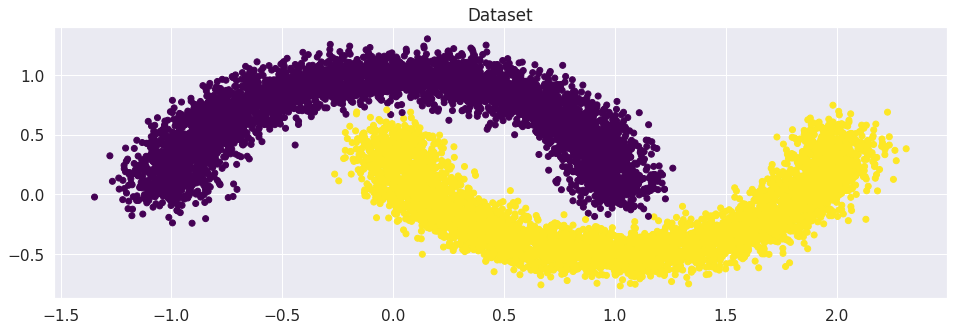

In [ ]:
plt.figure(figsize=(16, 5))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features,out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones((out_features)))

    def forward(self, x):
        x = x @ self.weights 
        if self.bias:
            x +=  self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[0.3367],
         [0.1288]], requires_grad=True), Parameter containing:
 tensor([1.], requires_grad=True)]

**ОТВЕТ: 3 обучаемых параметра**

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        outp = outp.view(-1)
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if it == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            num_stop_iter = it + epoch * len(train_dataloader)
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 59
Batch accuracy: 0.75
Iteration: 118
Batch accuracy: 0.8359375
Iteration: 177
Batch accuracy: 0.828125
Iteration: 236
Batch accuracy: 0.8203125
Iteration: 295
Batch accuracy: 0.8125
Iteration: 354
Batch accuracy: 0.8203125
Iteration: 413
Batch accuracy: 0.8203125
Iteration: 472
Batch accuracy: 0.8203125
Iteration: 531
Batch accuracy: 0.8203125
Iteration: 590
Batch accuracy: 0.8203125
Iteration: 649
Batch accuracy: 0.8203125

Iteration: 700.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

In [ ]:
print(f'Чтобы алгоритм сошелся потребовалось {num_stop_iter} итераций.')

Чтобы алгоритм сошелся потребовалось 700 итераций.


### Визуализируем результаты

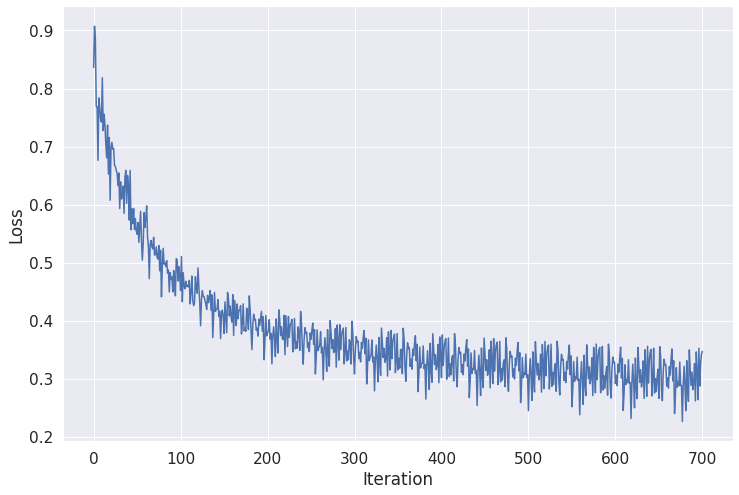

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

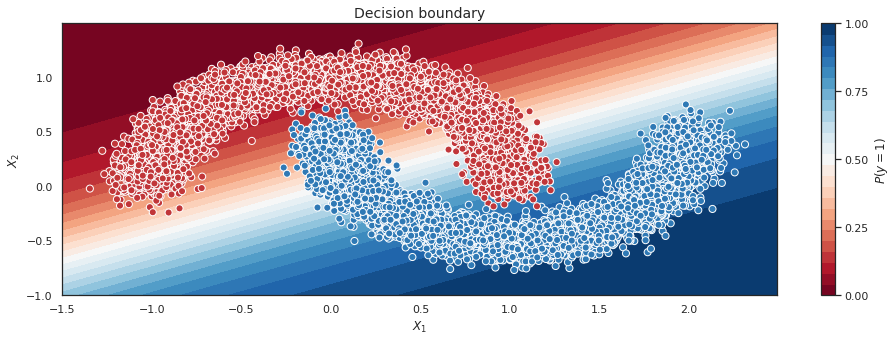

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 5))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  linear_regression(x_batch)
        probabilities =  1. / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
accuracy = accuracy_score(y_val_t, y_pred)

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

In [ ]:
print(f'После обучения accuracy = {accuracy}')

После обучения accuracy = 0.8648


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
valid_dataloader =  DataLoader(val_dataset, batch_size=128, drop_last=True)

In [ ]:
print(f'Data size:\n\t train {len(train_dataset)},\n\t valid {len(val_dataset)}')
print(f'Data shape:\n\t features {train_dataset[0][0].shape},\n\t target {type(val_dataset[0][1])}')

Data size:
	 train 60000,
	 valid 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [ ]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    activation,
    nn.Linear(128, 128),
    activation,
    nn.Linear(128, 10)
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model, (784,), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [128, 784]               0
            Linear-2                 [128, 128]         100,480
               ELU-3                 [128, 128]               0
            Linear-4                 [128, 128]          16,512
               ELU-5                 [128, 128]               0
            Linear-6                  [128, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forward/backward pass size (MB): 1.28
Params size (MB): 0.45
Estimated Total Size (MB): 2.11
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum(dim=0)
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8912259615384616
Loader: valid. Accuracy: 0.9446113782051282
Epoch: 2
Loader: train. Accuracy: 0.9492020566239316
Loader: valid. Accuracy: 0.9573317307692307
Epoch: 3
Loader: train. Accuracy: 0.9651442307692307
Loader: valid. Accuracy: 0.9660456730769231
Epoch: 4
Loader: train. Accuracy: 0.9704026442307693
Loader: valid. Accuracy: 0.9690504807692307
Epoch: 5
Loader: train. Accuracy: 0.9753772702991453
Loader: valid. Accuracy: 0.9709535256410257
Epoch: 6
Loader: train. Accuracy: 0.9804854433760684
Loader: valid. Accuracy: 0.9731570512820513
Epoch: 7
Loader: train. Accuracy: 0.9808526976495726
Loader: valid. Accuracy: 0.9760616987179487
Epoch: 8
Loader: train. Accuracy: 0.9834735576923077
Loader: valid. Accuracy: 0.9720552884615384
Epoch: 9
Loader: train. Accuracy: 0.9855769230769231
Loader: valid. Accuracy: 0.977363782051282
Epoch: 10
Loader: train. Accuracy: 0.9868790064102564
Loader: valid. Accuracy: 0.9747596153846154


In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
elu_accuracy

[0.9446113782051282,
 0.9573317307692307,
 0.9660456730769231,
 0.9690504807692307,
 0.9709535256410257,
 0.9731570512820513,
 0.9760616987179487,
 0.9720552884615384,
 0.977363782051282,
 0.9747596153846154]

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation,
        nn.Linear(128, 128),
        activation,
        nn.Linear(128, 10)
        )
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct =  (preds == y_batch).sum(dim=0)
                all =  len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            accuracy[k].append(epoch_correct/epoch_all)
            if k == 'valid':
              print(f'Эпоха {epoch+1}: valid accuracy {round(epoch_correct/epoch_all,4)}')
            else:
              print(f'Эпоха {epoch+1}: train accuracy {round(epoch_correct/epoch_all,4)}')
        print('------------------------------')
    
    return accuracy["valid"]   

In [ ]:
plain_accuracy = test_activation_function(Identical())

Эпоха 1: train accuracy 0.8734
Эпоха 1: valid accuracy 0.9117
------------------------------
Эпоха 2: train accuracy 0.9049
Эпоха 2: valid accuracy 0.9097
------------------------------
Эпоха 3: train accuracy 0.9072
Эпоха 3: valid accuracy 0.9084
------------------------------
Эпоха 4: train accuracy 0.9103
Эпоха 4: valid accuracy 0.9073
------------------------------
Эпоха 5: train accuracy 0.9116
Эпоха 5: valid accuracy 0.9169
------------------------------
Эпоха 6: train accuracy 0.9123
Эпоха 6: valid accuracy 0.917
------------------------------
Эпоха 7: train accuracy 0.9139
Эпоха 7: valid accuracy 0.9123
------------------------------
Эпоха 8: train accuracy 0.9135
Эпоха 8: valid accuracy 0.9174
------------------------------
Эпоха 9: train accuracy 0.9144
Эпоха 9: valid accuracy 0.9084
------------------------------
Эпоха 10: train accuracy 0.9161
Эпоха 10: valid accuracy 0.9165
------------------------------


In [ ]:
relu_accuracy = test_activation_function(nn.ReLU())

Эпоха 1: train accuracy 0.867
Эпоха 1: valid accuracy 0.9279
------------------------------
Эпоха 2: train accuracy 0.9351
Эпоха 2: valid accuracy 0.9448
------------------------------
Эпоха 3: train accuracy 0.9534
Эпоха 3: valid accuracy 0.9615
------------------------------
Эпоха 4: train accuracy 0.9622
Эпоха 4: valid accuracy 0.9623
------------------------------
Эпоха 5: train accuracy 0.9674
Эпоха 5: valid accuracy 0.9694
------------------------------
Эпоха 6: train accuracy 0.9743
Эпоха 6: valid accuracy 0.9671
------------------------------
Эпоха 7: train accuracy 0.9768
Эпоха 7: valid accuracy 0.9714
------------------------------
Эпоха 8: train accuracy 0.9786
Эпоха 8: valid accuracy 0.9677
------------------------------
Эпоха 9: train accuracy 0.9807
Эпоха 9: valid accuracy 0.9723
------------------------------
Эпоха 10: train accuracy 0.9826
Эпоха 10: valid accuracy 0.9736
------------------------------


In [ ]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU(0.1))

Эпоха 1: train accuracy 0.8804
Эпоха 1: valid accuracy 0.9372
------------------------------
Эпоха 2: train accuracy 0.9448
Эпоха 2: valid accuracy 0.9565
------------------------------
Эпоха 3: train accuracy 0.9603
Эпоха 3: valid accuracy 0.9618
------------------------------
Эпоха 4: train accuracy 0.9677
Эпоха 4: valid accuracy 0.9677
------------------------------
Эпоха 5: train accuracy 0.9732
Эпоха 5: valid accuracy 0.9702
------------------------------
Эпоха 6: train accuracy 0.9759
Эпоха 6: valid accuracy 0.9719
------------------------------
Эпоха 7: train accuracy 0.9808
Эпоха 7: valid accuracy 0.969
------------------------------
Эпоха 8: train accuracy 0.9813
Эпоха 8: valid accuracy 0.9749
------------------------------
Эпоха 9: train accuracy 0.9848
Эпоха 9: valid accuracy 0.9774
------------------------------
Эпоха 10: train accuracy 0.986
Эпоха 10: valid accuracy 0.9783
------------------------------


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

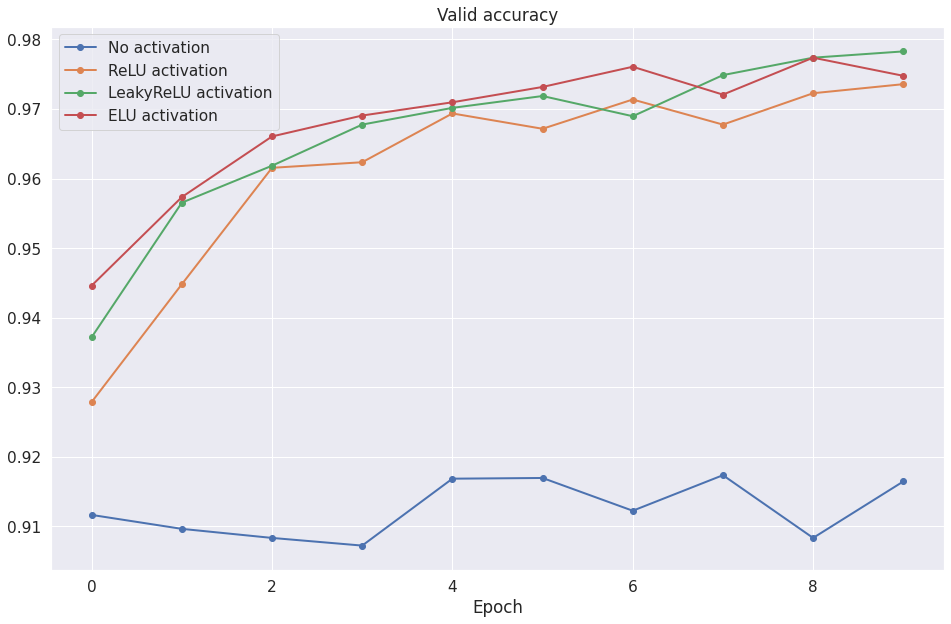

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, marker="o")
plt.legend()
plt.xlabel("Epoch")
plt.show()

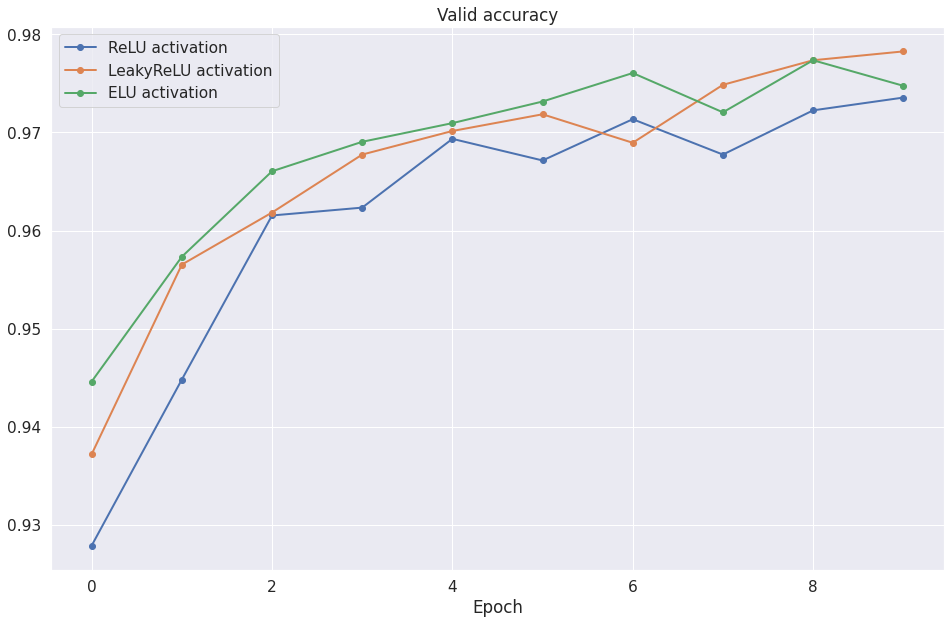

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, marker="o")
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

In [ ]:
# автоматизация вывода необходимого ответа
accuracies = {'No_act': plain_accuracy[-1],
              'ELU': elu_accuracy[-1],
              'ReLU': relu_accuracy[-1],
              'Leaky_ReLU': leaky_relu_accuracy[-1],
              }
values = [(value, key) for key, value in accuracies.items()]
max_val, act = (round(max(values)[0],4), max(values)[1])

print(f'Наивысший accuracy к концу обучения показала активация {act} с результатом {max_val}')

Наивысший accuracy к концу обучения показала активация Leaky_ReLU с результатом 0.9783


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-04-05 20:06:36--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-04-05 20:06:37--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   124KB/s    in 0.4s    

2022-04-05 20:06:38 (124 KB/s) - ‘sample_photo.jpg’ saved [49337/4

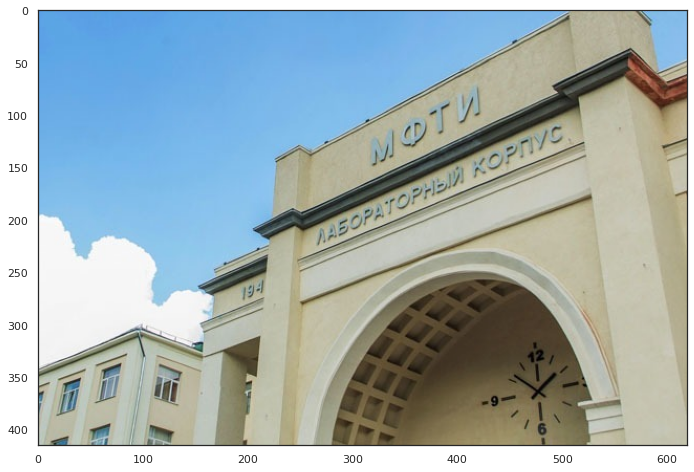

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
kernels = torch.tensor([[[0, 0, 0],
                         [0, 1, 0],
                         [0, 0, 0]],
                        
                        [[0, 1, 0],
                         [0, -2, 0],
                         [0, 1, 0]],
                        
                        [[0, 0, 0],
                         [1, -2, 1],
                         [0, 0, 0]],
                        
                        [[0, 1, 0],
                         [1, -4, 1],
                         [0, 1, 0]],
                        
                        [[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]],
                        
                        [[0.0625, 0.125, 0.0625],
                         [0.125, 0.25, 0.125],
                         [0.0625, 0.125, 0.0625]],
                        
                        [[1, 0, 0],
                         [0, 1, 0],
                         [0, 0, 1]],
                        
                        [[1, 0, -1],
                         [2, 0, -2],
                         [1, 0, -1]],
                        
                        [[-6, -3, 0],
                         [-3, 1, 3],
                         [0, 3, 6]]])

In [ ]:
def print_img(kernel):
  img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
  kernel = kernel.reshape(1, 1, 3, 3).type(torch.float32)
  kernel = kernel.repeat(3, 3, 1, 1)
  img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
  img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
  result = F.conv2d(img_t, kernel)[0]
  result_np = result.permute(1, 2, 0).numpy() / 256 / 3
  return result_np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


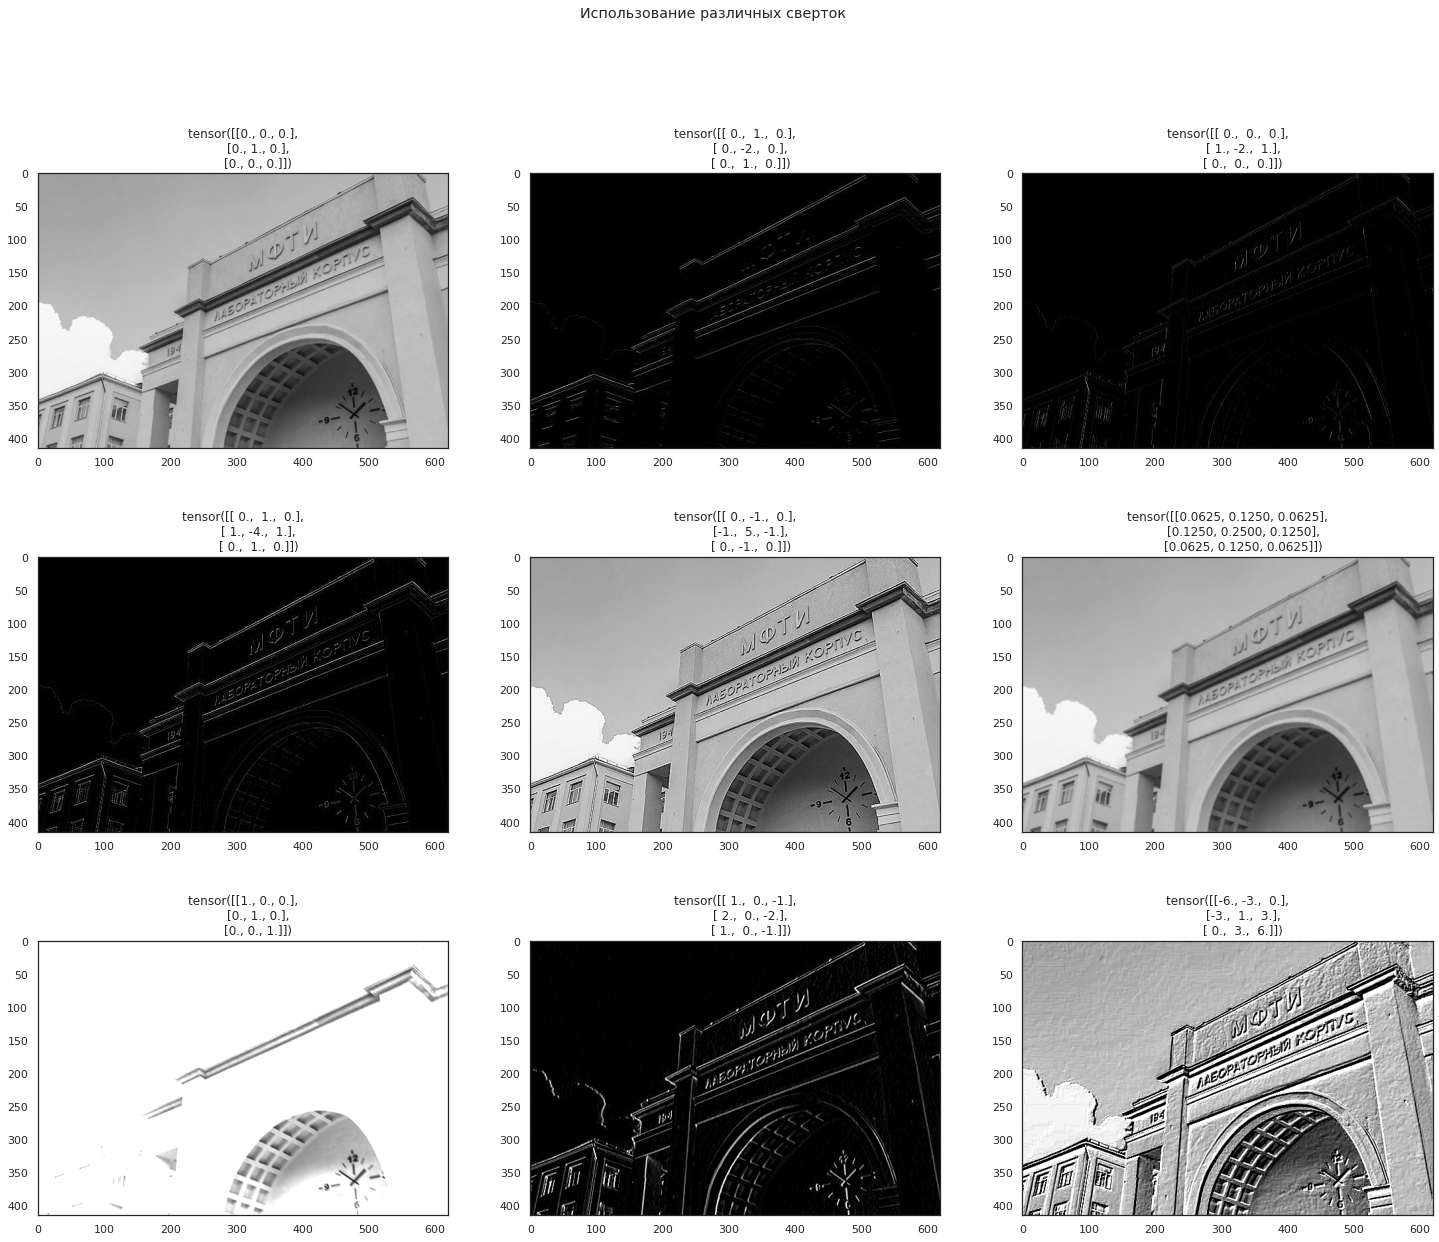

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(25, 20), sharey=False)
ax = axes.ravel()
fig.suptitle('Использование различных сверток')

for i, kernel in enumerate(kernels):
  
  ax[i].imshow(print_img(kernel))
  ax[i].set_title(kernel)
 
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

- 1) - Е
- 2) - Д
- 3) - А
- 4) - В
- 5) - Б
- 6) - Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)

        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum(dim=0)
            all =  len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8803418803418803
Loader: valid. Accuracy: 0.9675480769230769
Epoch: 2
Loader: train. Accuracy: 0.9704861111111112
Loader: valid. Accuracy: 0.9792668269230769
Epoch: 3
Loader: train. Accuracy: 0.9794838408119658
Loader: valid. Accuracy: 0.9801682692307693
Epoch: 4
Loader: train. Accuracy: 0.9832064636752137
Loader: valid. Accuracy: 0.9842748397435898
Epoch: 5
Loader: train. Accuracy: 0.9858774038461539
Loader: valid. Accuracy: 0.9854767628205128
Epoch: 6
Loader: train. Accuracy: 0.9880642361111112
Loader: valid. Accuracy: 0.9860777243589743
Epoch: 7
Loader: train. Accuracy: 0.9896501068376068
Loader: valid. Accuracy: 0.9863782051282052
Epoch: 8
Loader: train. Accuracy: 0.9916199252136753
Loader: valid. Accuracy: 0.9856770833333334
Epoch: 9
Loader: train. Accuracy: 0.9923377403846154
Loader: valid. Accuracy: 0.9857772435897436
Epoch: 10
Loader: train. Accuracy: 0.9930221688034188
Loader: valid. Accuracy: 0.9878806089743589


In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

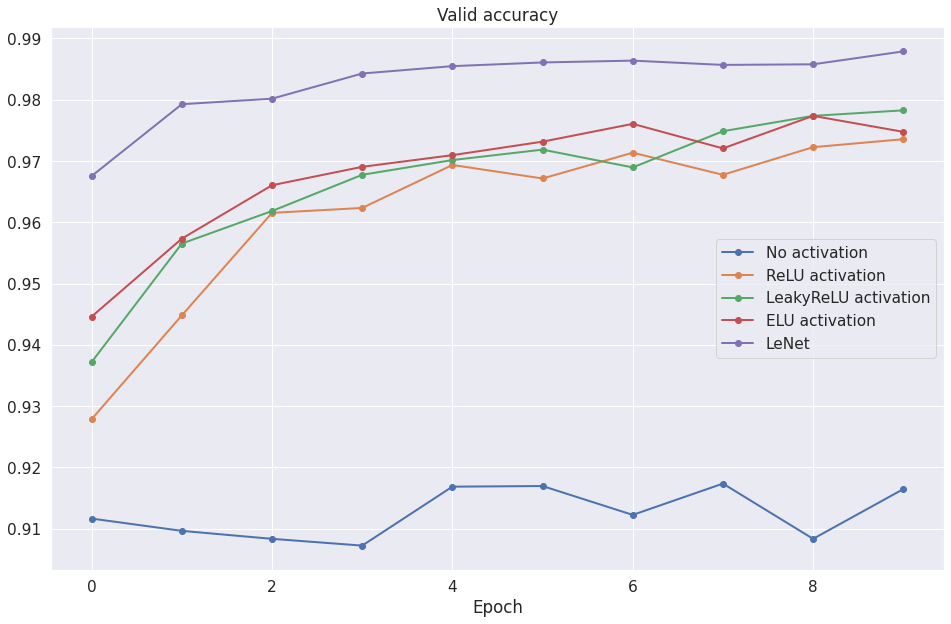

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2, marker="o")
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2, marker="o")
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [ ]:
accuracy = round(lenet_accuracy[-1], 2)
print(f'После обучения модели LeNet accuracy на валидационной выборке {accuracy}')

После обучения модели LeNet accuracy на валидационной выборке 0.99
